<a href="https://colab.research.google.com/github/thenourjr/Deep-Learning/blob/main/assi1_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Download data**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(dataset_train, dataset_val), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

print(dataset_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

### **image processing**

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_data = dataset_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(1)
val_data = dataset_val.map(preprocess).batch(BATCH_SIZE).prefetch(1)

### ResNet50 + Feature **Extraction**

In [4]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Feature **Extraction**

In [5]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - accuracy: 0.9627 - loss: 0.0989 - val_accuracy: 0.9895 - val_loss: 0.0274
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.9861 - loss: 0.0385 - val_accuracy: 0.9905 - val_loss: 0.0265
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 132ms/step - accuracy: 0.9881 - loss: 0.0325 - val_accuracy: 0.9897 - val_loss: 0.0295
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - accuracy: 0.9904 - loss: 0.0280 - val_accuracy: 0.9914 - val_loss: 0.0236
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 132ms/step - accuracy: 0.9910 - loss: 0.0233 - val_accuracy: 0.9914 - val_loss: 0.0268


### **Fine-Tuning**

In [6]:
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    epochs=2,
    validation_data=val_data
)

Epoch 1/2
582/582 ━━━━━━━━━━━━━━━━━━━━ 119s 170ms/step - accuracy: 0.9847 - loss: 0.0394 - val_accuracy: 0.9905 - val_loss: 0.0286
Epoch 2/2
582/582 ━━━━━━━━━━━━━━━━━━━━ 88s 147ms/step - accuracy: 0.9941 - loss: 0.0151 - val_accuracy: 0.9914 - val_loss: 0.0280


### Confusion **Matrix**

146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step


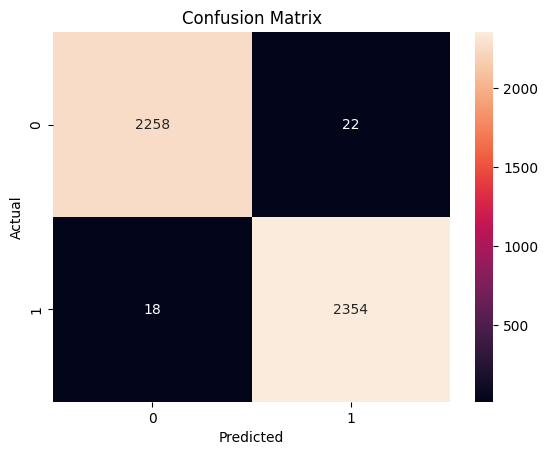

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2280
           1       0.99      0.99      0.99      2372

    accuracy                           0.99      4652
   macro avg       0.99      0.99      0.99      4652
weighted avg       0.99      0.99      0.99      4652



In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(val_data)
y_pred_classes = (y_pred > 0.5).astype("int32")

y_true = np.concatenate([y for x, y in val_data], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_true, y_pred_classes))

### **Accuracy & Loss**

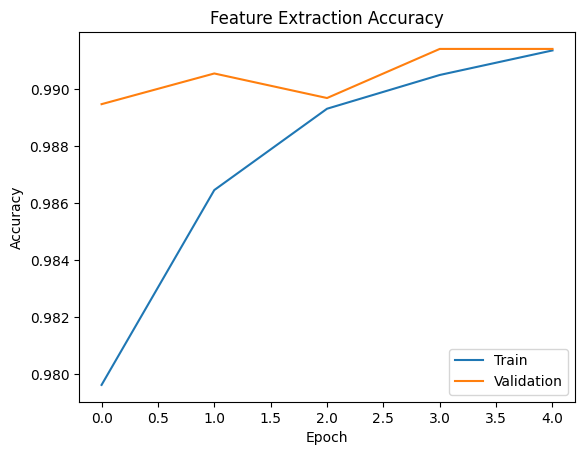

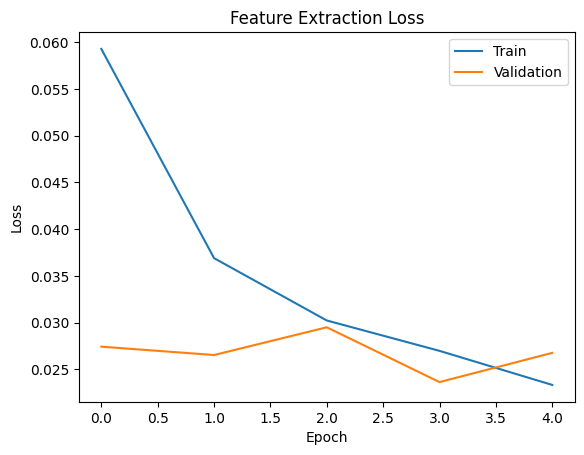

In [7]:

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Feature Extraction Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Feature Extraction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

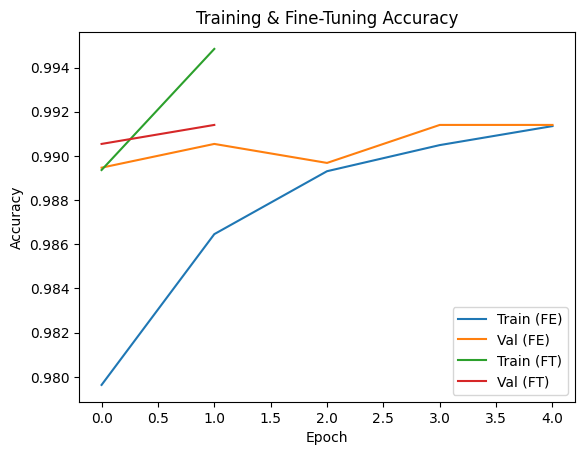

In [11]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])

plt.title('Training & Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train (FE)', 'Val (FE)', 'Train (FT)', 'Val (FT)'])
plt.show()

### **final evaluation**

In [8]:
loss, acc = model.evaluate(val_data)
print("Final Validation Accuracy:", acc)

146/146 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.9905 - loss: 0.0287
Final Validation Accuracy: 0.9914015531539917


In [10]:
model.save("cats_vs_dogs_resnet50_model.h5")